<a href="https://colab.research.google.com/github/saeedzou/Deep-Learning-Project/blob/main/Phase%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This block downloads and preprocesses the needed data for the project
!git clone https://github.com/XL2248/MSCTD
!cp MSCTD/MSCTD_data/ende/eng* .
!cp MSCTD/MSCTD_data/ende/ima* .
!cp MSCTD/MSCTD_data/ende/sent* .
!rm -rf MSCTD
!pip -q install --upgrade --no-cache-dir gdown
!gdown 1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
!gdown 1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
!gdown 1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
!unzip -q train_ende.zip
!unzip -q dev.zip
!unzip -q test.zip
!mv train_ende train
!mkdir train/image
!mkdir dev/image
!mkdir test/image
!mv train/*.jpg train/image
!mv dev/*.jpg dev/image
!mv test/*.jpg test/image
!mv *train.txt train
!mv *dev.txt dev
!mv *test.txt test

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (617/617), done.
Updating files: 100% (934/934), done.
Downloading...
From: https://drive.google.com/uc?id=1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
To: /content/train_ende.zip
100% 2.90G/2.90G [00:17<00:00, 167MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
To: /content/dev.zip
100% 638M/638M [00:02<00:00, 236MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
To: /content/test.zip
100% 641M/641M [00:03<00:00, 180MB/s]
replace train_ende/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: mv: cannot move 'train_ende' to 'train/train_ende': Directory not empty
mkdir: cannot create directory ‘train/image’

In [1]:
import numpy as np
import pandas as pd
import nltk
import nltk.tokenize as tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
from torchvision import transforms
import os
import string
import re
import gc
import random
import matplotlib.pyplot as plt
!pip install -q transformers
import seaborn as sns
from transformers import BertTokenizer
from transformers import BertModel
from PIL import Image
!pip install -q timm
import timm
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
class MSCTD(Dataset):
    """
    :param root: root path of the dataset
    :param split: train, dev, test
    :param image_transform: transform for image
    :param text_transform: transform for text
    :param sentiment_transform: transform for sentiment
    :param has_data: dict, whether the dataset has image, text
    :param text_path: path of the text file
    :param image_path: path of the image folder
    :param sentiment_path: path of the sentiment file
    :param image_index_path: path of the image index file

    :return: combination of image, sentiment, text, image_index

    Example:
    >>> from torchvision import transforms
    >>> image_transform = transforms.Compose([
    >>>     transforms.Resize((640, 1280)),
    >>>     transforms.Lambda(lambda x: x.permute(1, 2, 0))
    >>> ])
    >>> text_transform = None
    >>> sentiment_transform = None
    >>> dataset = MSCTD(root='data', split='train', image_transform=image_transform,
    >>>                 text_transform=text_transform, sentiment_transform=sentiment_transform)
    >>> image, text, sentiment = dataset[0]

    """
    def __init__(self, root, split, image_transform=None, text_transform=None, sentiment_transform=None,
                 has_data={'image': True, 'text': True}, text_path=None, image_path=None, sentiment_path=None,
                 image_index_path=None):
        data_path = os.path.join(root, split)
        default_path = {
            'text': os.path.join(data_path, 'english_' + split + '.txt'),
            'image': os.path.join(data_path, 'image'),
            'sentiment': os.path.join(data_path, 'sentiment_' + split + '.txt'),
            'image_index': os.path.join(data_path, 'image_index_' + split + '.txt'),
        }
        self.image = [] if has_data['image'] else None
        self.image_transform = image_transform
        self.image_path = image_path if image_path else default_path['image']
        self.text = [] if has_data['text'] else None
        self.text_transform = text_transform
        self.text_path = text_path if text_path else default_path['text']
        self.sentiment_path = sentiment_path if sentiment_path else default_path['sentiment']
        self.image_index_path = image_index_path if image_index_path else default_path['image_index']
        self.sentiment = []
        self.image_index = []
        self.sentiment_transform = sentiment_transform
        self.load_data()
        
    def load_data(self):
        self.sentiment = np.loadtxt(self.sentiment_path, dtype=int)
        if self.text is not None:
            with open(self.text_path, 'r') as f:
                self.text = f.readlines()
            self.text = [x.strip() for x in self.text]
        with open(self.image_index_path, 'r') as f:
            data = f.readlines()
        self.image_index = [list(map(int, x[1:-2].split(','))) for x in data]

    def __getitem__(self, index):
        image = None
        text = None
        sentiment = self.sentiment[index]
        if self.image is not None:
            imag_path = os.path.join(self.image_path, str(index)+'.jpg')
            image = read_image(imag_path)
            if self.image_transform:
                image = self.image_transform(image)
        if self.text is not None:
            text = self.text[index]
            if self.text_transform:
                text = self.text_transform(text)
        if self.sentiment_transform:
            sentiment = self.sentiment_transform(sentiment)
        if text is not None and image is not None:
            return image, text, sentiment
        elif text is not None:
            return text, sentiment
        elif image is not None:
            return image, sentiment
        else:
            raise Exception('Either image or text should be not None')

    def __len__(self):
        return len(self.sentiment)

In [3]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
MSCTD_train = MSCTD(root='.', split='train', image_transform=image_transform, has_data={'image': True, 'text': True})
MSCTD_dev = MSCTD(root='.', split='dev', image_transform=image_transform, has_data={'image': True, 'text': True})
MSCTD_test = MSCTD(root='.', split='test', image_transform=image_transform, has_data={'image': True, 'text': True})

In [4]:
def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def text_preprocessor(dataset):
      # preprocess text
      dataset.text = [preprocess_text(text) for text in dataset.text]

def preprocess_text(text):
      # Replace contractions with original text
  text = re.sub(r'(\b[Aa]in\'t\b)', "am not", text)
  text = re.sub(r'(\b[Hh]a\'t\b)', "has", text)
  text = re.sub(r'(\b[Ii]\'m\b)', "i am", text)
  text = re.sub(r'(\b\'s\b)', " is", text)
  text = re.sub(r'(\b\'re\b)', " are", text)
  text = re.sub(r'(\b\'ve\b)', " have", text)
  text = re.sub(r'(\b\'d\b)', " would", text)
  text = re.sub(r'(\b\'ll\b)', " will", text)
  text = re.sub(r'(\b[Ss]han\'t\b)', "shall not", text)
  text = re.sub(r'(\b[Ww]on\'t\b)', "will not", text)
  text = re.sub(r'(\b[Ww]ouldn\'t\b)', "would not", text)
  text = re.sub(r'(\b[Dd]on\'t\b)', "do not", text)
  text = re.sub(r'(\b[Cc]an\'t\b)', "can not", text)
  text = re.sub(r'(\b[Ii]s\'nt\b)', "is not", text)
  text = re.sub(r'(\b[Ww]eren\'t\b)', "were not", text)
  text = re.sub(r'(\b[Hh]aven\'t\b)', "have not", text)
  text = re.sub(r'(\b[Hh]adn\'t\b)', "had not", text)
  text = re.sub(r'(\b[Hh]asn\'t\b)', "has not", text)
  text = re.sub(r'(\b[Hh]adn\'t\b)', "had not", text)
  text = re.sub(r'(\b[Dd]idn\'t\b)', "did not", text)

  # Remove punctuation
  text = text.translate(str.maketrans("", "", string.punctuation))

  # Convert to lowercase
  text = text.lower()

  # Tokenize text
  tokens = word_tokenize(text)

  # Remove stop words
  # tokens = [token for token in tokens if token not in stop_words]
  # Remove numbers
  tokens = [token for token in tokens if token.isalpha()]

  # Lemmatize tokens
  tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

  return ' '.join(tokens)

# Test the TextPreprocessor
text_preprocessor(MSCTD_train)
text_preprocessor(MSCTD_dev)
text_preprocessor(MSCTD_test)

# Part 1 Subpart 1

In [ ]:
# define a class that get a dataset and return tokenized dataset
class TokenizedDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=80):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __getitem__(self, index):
        image, text, sentiment = self.dataset[index]
        text = self.tokenizer.encode_plus(text, add_special_tokens=True, max_length=self.max_length, 
                                          padding='max_length', truncation=True, return_tensors='pt')
        return image, text, sentiment
    def __len__(self):
        return len(self.dataset)

# define a image_encoder model using resnet50 on timm
class ImageEncoder(nn.Module):
    def __init__(self, is_trainable=True):
        super(ImageEncoder, self).__init__()
        self.resnet = timm.create_model('resnet50', pretrained=True)
        self.resnet.fc = nn.Identity()
        if not is_trainable:
            for param in self.resnet.parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.resnet(x)

# define a text_encoder model using bert-base-uncased on huggingface
class TextEncoder(nn.Module):
    def __init__(self, is_trainable=True):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        if not is_trainable:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = {k: v.squeeze(1) for k, v in x.items()}
        return self.bert(**x).last_hidden_state[:, 0, :]

# define a MLP classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize datasets
max_length = 25
tokenized_train = TokenizedDataset(MSCTD_train, tokenizer, max_length)
tokenized_dev = TokenizedDataset(MSCTD_dev, tokenizer, max_length)
tokenized_test = TokenizedDataset(MSCTD_test, tokenizer, max_length)

# dataloader
train_dataloader_tokenized = DataLoader(tokenized_train, batch_size=32, shuffle=True)
dev_dataloader_tokenized = DataLoader(tokenized_dev, batch_size=32, shuffle=True)
test_dataloader_tokenized = DataLoader(tokenized_test, batch_size=32, shuffle=True)

# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define image_encoder and text_encoder
image_encoder = ImageEncoder(is_trainable=False).to(device)
text_encoder = TextEncoder(is_trainable=True).to(device)

# define the classifier
classifier = MLPClassifier(2048+768, 512, 3).to(device)

# define the optimizer
optimizer = optim.Adam(list(text_encoder.parameters()) + list(classifier.parameters()), lr=1e-5)

# define the loss function
criterion = nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_losses = []
dev_losses = []
train_accs = []
dev_accs = []
num_epochs = 10
for epoch in range(num_epochs):
    # train
    train_loss = 0
    train_acc = 0
    total_samples = 0
    for images, texts, labels in tqdm(train_dataloader_tokenized):
        images = images.to(device)
        labels = labels.to(device)
        texts = texts.to(device)
        # get the image and text embeddings
        image_embeddings = image_encoder(images)
        text_embeddings = text_encoder(texts)
        # concatenate the image and text embeddings
        embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
        # get the predictions
        predictions = classifier(embeddings)
        # calculate the loss
        loss = F.cross_entropy(predictions, labels)
        # calculate the accuracy
        acc = (predictions.argmax(dim=1) == labels).float().sum()
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # update the loss and accuracy
        train_loss += loss.item()
        train_acc += acc.item()
        total_samples += labels.size(0)
    # calculate the average loss and accuracy
    train_loss /= len(train_dataloader_tokenized)
    train_acc /= total_samples
    # save the loss and accuracy
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # evaluate
    dev_loss = 0
    dev_acc = 0
    total_samples = 0
    with torch.no_grad():
        for images, texts, labels in tqdm(dev_dataloader_tokenized):
            images = images.to(device)
            labels = labels.to(device)
            texts = texts.to(device)
            # get the image and text embeddings
            image_embeddings = image_encoder(images)
            text_embeddings = text_encoder(texts)
            # concatenate the image and text embeddings
            embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
            # get the predictions
            predictions = classifier(embeddings)
            # calculate the loss
            loss = F.cross_entropy(predictions, labels)
            # calculate the accuracy
            acc = (predictions.argmax(dim=1) == labels).float().sum()
            # update the loss and accuracy
            dev_loss += loss.item()
            dev_acc += acc.item()
            total_samples += labels.size(0)
    # calculate the average loss and accuracy
    dev_loss /= len(dev_dataloader_tokenized)
    dev_acc /= total_samples
    # save the loss and accuracy
    dev_losses.append(dev_loss)
    dev_accs.append(dev_acc)
    # print the loss and accuracy
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_acc:.4f}')

100%|██████████| 159/159 [01:15<00:00,  2.10it/s]


Epoch 1/10, Train Loss: 0.9538, Train Acc: 0.5910, Dev Loss: 0.9388, Dev Acc: 0.6009


100%|██████████| 159/159 [01:15<00:00,  2.09it/s]


Epoch 2/10, Train Loss: 0.8611, Train Acc: 0.6849, Dev Loss: 0.9400, Dev Acc: 0.5941


100%|██████████| 159/159 [01:15<00:00,  2.10it/s]


Epoch 3/10, Train Loss: 0.8083, Train Acc: 0.7407, Dev Loss: 0.9394, Dev Acc: 0.6002


100%|██████████| 159/159 [01:16<00:00,  2.08it/s]


Epoch 4/10, Train Loss: 0.7710, Train Acc: 0.7789, Dev Loss: 0.9452, Dev Acc: 0.5964


100%|██████████| 159/159 [01:15<00:00,  2.10it/s]


Epoch 5/10, Train Loss: 0.7523, Train Acc: 0.7981, Dev Loss: 0.9533, Dev Acc: 0.5897


100%|██████████| 159/159 [01:15<00:00,  2.11it/s]


Epoch 6/10, Train Loss: 0.7384, Train Acc: 0.8116, Dev Loss: 0.9532, Dev Acc: 0.5910


100%|██████████| 159/159 [01:14<00:00,  2.14it/s]


Epoch 7/10, Train Loss: 0.7278, Train Acc: 0.8227, Dev Loss: 0.9508, Dev Acc: 0.5924


100%|██████████| 159/159 [01:15<00:00,  2.10it/s]


Epoch 8/10, Train Loss: 0.7192, Train Acc: 0.8315, Dev Loss: 0.9619, Dev Acc: 0.5828


100%|██████████| 159/159 [01:14<00:00,  2.14it/s]


Epoch 9/10, Train Loss: 0.7125, Train Acc: 0.8384, Dev Loss: 0.9559, Dev Acc: 0.5873


100%|██████████| 159/159 [01:15<00:00,  2.12it/s]

Epoch 10/10, Train Loss: 0.7059, Train Acc: 0.8448, Dev Loss: 0.9546, Dev Acc: 0.5914


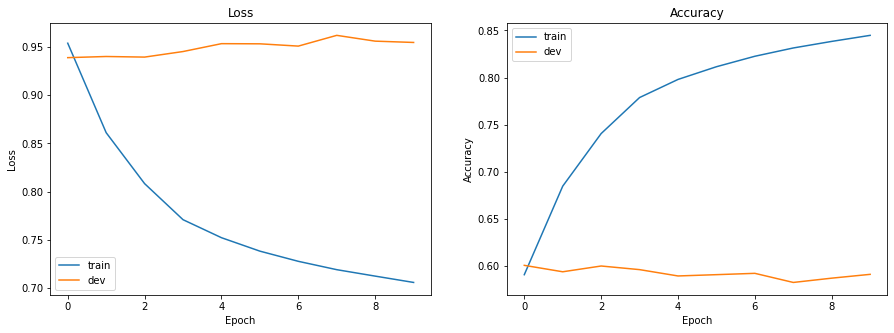

In [ ]:
# plot the loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(dev_losses, label='dev')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].title.set_text('Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(dev_accs, label='dev')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].title.set_text('Accuracy')
ax[1].legend()
plt.show()


In [ ]:
test_loss = 0
test_acc = 0
total_samples = 0
with torch.no_grad():
    for images, texts, labels in tqdm(test_dataloader_tokenized):
        images = images.to(device)
        labels = labels.to(device)
        texts = texts.to(device)
        # get the image and text embeddings
        image_embeddings = image_encoder(images)
        text_embeddings = text_encoder(texts)
        # concatenate the image and text embeddings
        embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
        # get the predictions
        predictions = classifier(embeddings)
        # calculate the loss
        loss = F.cross_entropy(predictions, labels)
        # calculate the accuracy
        acc = (predictions.argmax(dim=1) == labels).float().sum()
        # update the loss and accuracy
        test_loss += loss.item()
        test_acc += acc.item()
        total_samples += labels.size(0)
# calculate the average loss and accuracy
test_loss /= len(test_dataloader_tokenized)
test_acc /= total_samples
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

100%|██████████| 159/159 [01:21<00:00,  1.95it/s]

Test loss: 0.9487387879089739, Test accuracy: 0.5983816854154332


# Part 1 Subpart 2

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# define a class that get a dataset and return tokenized dataset
class TokenizedDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=80):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __getitem__(self, index):
        image, text, sentiment = self.dataset[index]
        text = self.tokenizer.encode_plus(text, add_special_tokens=True, max_length=self.max_length, 
                                          padding='max_length', truncation=True, return_tensors='pt')
        return image, text, sentiment
    def __len__(self):
        return len(self.dataset)

# define a image_encoder model using resnet50 on timm
class ImageEncoder(nn.Module):
    def __init__(self, is_trainable=True):
        super(ImageEncoder, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()
        if not is_trainable:
            for param in self.vit.parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.vit(x)

# define a text_encoder model using bert-base-uncased on huggingface
class TextEncoder(nn.Module):
    def __init__(self, is_trainable=True):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        if not is_trainable:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = {k: v.squeeze(1) for k, v in x.items()}
        return self.bert(**x).last_hidden_state[:, 0, :]

# define a MLP classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize datasets
max_length = 25
tokenized_train = TokenizedDataset(MSCTD_train, tokenizer, max_length)
tokenized_dev = TokenizedDataset(MSCTD_dev, tokenizer, max_length)
tokenized_test = TokenizedDataset(MSCTD_test, tokenizer, max_length)

# dataloader
train_dataloader_tokenized = DataLoader(tokenized_train, batch_size=32, shuffle=True)
dev_dataloader_tokenized = DataLoader(tokenized_dev, batch_size=32, shuffle=True)
test_dataloader_tokenized = DataLoader(tokenized_test, batch_size=32, shuffle=True)

# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define image_encoder and text_encoder
image_encoder = ImageEncoder(is_trainable=True).to(device)
text_encoder = TextEncoder(is_trainable=True).to(device)

# define the classifier
classifier = MLPClassifier(768+768, 512, 3).to(device)

# define the optimizer
optimizer = optim.Adam(list(text_encoder.parameters()) + list(classifier.parameters()) + list(image_encoder.parameters()), lr=1e-5)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_losses = []
dev_losses = []
train_accs = []
dev_accs = []
num_epochs = 10
for epoch in range(num_epochs):
    # train
    train_loss = 0
    train_acc = 0
    total_samples = 0
    for images, texts, labels in tqdm(train_dataloader_tokenized):
        images = images.to(device)
        labels = labels.to(device)
        texts = texts.to(device)
        # get the image and text embeddings
        image_embeddings = image_encoder(images)
        text_embeddings = text_encoder(texts)
        # concatenate the image and text embeddings
        embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
        # get the predictions
        predictions = classifier(embeddings)
        # calculate the loss
        loss = F.cross_entropy(predictions, labels)
        # calculate the accuracy
        acc = (predictions.argmax(dim=1) == labels).float().sum()
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # update the loss and accuracy
        train_loss += loss.item()
        train_acc += acc.item()
        total_samples += labels.size(0)
    # calculate the average loss and accuracy
    train_loss /= len(train_dataloader_tokenized)
    train_acc /= total_samples
    # save the loss and accuracy
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # evaluate
    dev_loss = 0
    dev_acc = 0
    total_samples = 0
    with torch.no_grad():
        for images, texts, labels in tqdm(dev_dataloader_tokenized):
            images = images.to(device)
            labels = labels.to(device)
            texts = texts.to(device)
            # get the image and text embeddings
            image_embeddings = image_encoder(images)
            text_embeddings = text_encoder(texts)
            # concatenate the image and text embeddings
            embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
            # get the predictions
            predictions = classifier(embeddings)
            # calculate the loss
            loss = F.cross_entropy(predictions, labels)
            # calculate the accuracy
            acc = (predictions.argmax(dim=1) == labels).float().sum()
            # update the loss and accuracy
            dev_loss += loss.item()
            dev_acc += acc.item()
            total_samples += labels.size(0)
    # calculate the average loss and accuracy
    dev_loss /= len(dev_dataloader_tokenized)
    dev_acc /= total_samples
    # save the loss and accuracy
    dev_losses.append(dev_loss)
    dev_accs.append(dev_acc)
    # print the loss and accuracy
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_acc:.4f}')

100%|██████████| 159/159 [01:58<00:00,  1.34it/s]


Epoch 1/10, Train Loss: 0.9526, Train Acc: 0.5824, Dev Loss: 0.9367, Dev Acc: 0.6038


100%|██████████| 159/159 [01:54<00:00,  1.38it/s]


Epoch 2/10, Train Loss: 0.8543, Train Acc: 0.6929, Dev Loss: 0.9460, Dev Acc: 0.5923


  1%|          | 7/633 [00:10<15:59,  1.53s/it]